In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from collections import OrderedDict
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import glob, re
import seaborn as sns
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 100)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.utils.multiclass import type_of_target # used to check the Y labels are appropriate for classification
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.utils import shuffle
from scipy import interp

def convert_nan_to_val(data, value=0):
    data[pd.isnull(data)] = value
    return data

In [11]:
def make_bar_plts(model_aucs, name_list, y_lim=[]):
    for i in range(len(name_list)):
        avg = []
        std = []
        names = []
        for data_set in model_aucs:
            if data_set =='log':
                continue
            names.append(data_set)
            avg.append(model_aucs[data_set][i].mean())
            std.append(model_aucs[data_set][i].std())
        x = [i for i in range(len(names))]
        plt.bar(x, avg, yerr=std)
        plt.xticks(x, names, rotation='vertical')
        for ind, v in enumerate(avg):
            plt.text(ind-0.4, v+0.05, '%.2f'%(v))
        plt.title(ds_names[i])
        if len(y_lim) != 0:
            plt.ylim(y_lim)
        plt.show()

In [3]:
#### Use this if NOT doing a fresh modeling fitting analysis
pickle_file = './YES_bn_ds_models_and_sigfeat_NO_log_NO_standscal_NO_multi_mapped_labels.pkl'
### The non-batch corrected pickle for the dataset
# pickle_file = './NO_bn_dataset_models_and_sigfeat_YES_log.pkl'
datasets = pickle.load(open(pickle_file, 'rb'))

In [6]:
bn = True

if bn:
    path = './bn_pickles/*.pkl'
else:
    path = './pickles/*.pkl'
    
datasets = OrderedDict()
for fn in sorted(glob.glob(path)):
    data = pd.read_pickle(open(fn,'rb'))
    datasets[data[0]['study']] = data
    
# if bn:
#     for k, v in datasets.items():
#         for ds in v:
#             if bn:
#                 ds['labels'] = pd.DataFrame(ds['labels'])
#                 ds['features'] = pd.DataFrame(ds['features'])

In [29]:
from random import randint
def extract_data(ds, log_scale=False):
    ds['labels'] = ds['labels']*1
    vals = ds['labels'].values
    try:
        vals = [item for sublist in vals for item in sublist]
    except:
        pass
    labels = set(vals)
    
    y = ds['labels'].values.copy().ravel().astype(int)
    X = ds['features'].values.copy()
    X = convert_nan_to_val(X, value=0)
    X[np.isinf(X)] = 0
    if log_scale: # outdated....need to change it over to the list of prelogged files
        if 'IPO' in ds['data_set'] or 'XCMS' in ds['data_set']:
            X[X==0] = 1
            X = np.log2(X)
    if ds['study'] == 'MTBLS423': # dont think this study is included anymore
        y[y==6] = 1
    return X, y, labels

def fit_l1_log_reg(X_in, y_in, labels, hstck=[]):
    X = X_in.copy()
    y = y_in.copy()
    if len(hstck) != 0:
        conf_size = hstck.shape[1]
        scaler = StandardScaler()
        hstck = scaler.fit_transform(hstck)
        X = np.hstack((X,hstck))
    X,y = shuffle(X,y)
    clf = LogisticRegressionCV(scoring='roc_auc', penalty='l1', solver='liblinear', tol=1e-4, intercept_scaling=1, max_iter=500)#, random_state=5)
    cv = StratifiedKFold(n_splits=3, shuffle=True)#, random_state=5)
    aucs = []
    for train, test in cv.split(X,y):
        x_train, y_train = X[train], y[train]
        x_test,y_test = X[test], y[test]
        clf.fit(x_train, y_train)
        if len(labels) != 2:
            aucs.append(clf.score(x_test, y_test))
        else:
            y_pred = clf.predict_proba(x_test)
            fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
            auc_value = metrics.auc(fpr, tpr)
            aucs.append(auc_value)   
        if len(hstck) != 0:
            print('coef for confounders: ', clf.coef_[0][-conf_size:])
#     if X.shape[1] < 10:
#         print(clf.coef_)
#         print(y_pred, y)
    
    auc = np.asarray(aucs)
    return auc

In [9]:
MTBLS28 = datasets['MTBLS28']
# datasets inside this study are:
# m_mtbls28_NEG_v2_maf
# m_mtbls28_POS_v2_maf
# IPO_aligned_MTBLS28_neg
# IPO_aligned_MTBLS28_pos

# The various possible covariates are: 
# Factor Value[Gender] Male / Female
# Factor Value[Race] European American / African American
# Factor Value[Smoking] Current Smoker / Never Smoker / Former Smoker

# trying to add gender or other features to the ds['features'] and train a model
model_aucs = {'no mod':[],'log':[],'log_gender':[], 'log_smoker':[], 'log_race': [],
              'log_gender_smoker': [], 'log_gender_race':[], 'log_race_smoker':[],
              'log_gender_smoker_race':[], 'all_cov':[]}
for ds in MTBLS28:
    X,y, labels = extract_data(ds)
    model_aucs['no mod'].append(fit_l1_log_reg(X,y,labels))
# X is now the log-transformed version:
#     X,y, labels = extract_data(ds, log_scale=True)
#     model_aucs['log'].append(fit_l1_log_reg(X,y, labels))
# get the various combos of covariates:
    gender = ds['samples']['Factor Value[Gender]'].replace({'Male':0, 'Female':1})
    gender = np.expand_dims(gender, axis=1)
    race = ds['samples']['Factor Value[Race]'].replace({'European American':0, 'African American':1})
    race = np.expand_dims(race, axis=1)
    smoker = ds['samples']['Factor Value[Smoking]'].replace({'Never Smoker':0, 'Current Smoker':2, 'Former Smoker':1})
    smoker = np.expand_dims(smoker, axis=1)
# combine to get all combos as well
    g_r = np.hstack((gender, race))
    g_s = np.hstack((gender, smoker))
    r_s = np.hstack((race, smoker))
    g_s_r = np.hstack((g_s,race))
    
    combos = [gender, smoker, race, g_r, g_s, r_s, g_s_r]
    names = ['log_gender', 'log_smoker', 'log_race', 'log_gender_race',
             'log_gender_smoker', 'log_race_smoker', 'log_gender_smoker_race']
    for n, add_col in zip(names, combos):
        model_aucs[n].append(fit_l1_log_reg(X,y,labels, hstck=add_col))
    model_aucs['all_cov'].append(fit_l1_log_reg(g_s_r,y,labels))
    print(model_aucs)
    
    

/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475:

{'no mod': [array([0.84745401, 0.82434465, 0.85663354])], 'log': [], 'log_gender': [array([0.81756396, 0.83046841, 0.85537309])], 'log_smoker': [array([0.86126036, 0.81592895, 0.86387208])], 'log_race': [array([0.85311177, 0.80783555, 0.821017  ])], 'log_gender_smoker': [array([0.85962353, 0.8407105 , 0.83668251])], 'log_gender_race': [array([0.84378892, 0.85292222, 0.84586574])], 'log_race_smoker': [array([0.85677686, 0.86151697, 0.85526505])], 'log_gender_smoker_race': [array([0.83991033, 0.85252829, 0.82749928])], 'all_cov': [array([0.76933068, 0.79374373, 0.77234587])]}


/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475:

{'no mod': [array([0.84745401, 0.82434465, 0.85663354]), array([0.84891293, 0.88343361, 0.85267214])], 'log': [], 'log_gender': [array([0.81756396, 0.83046841, 0.85537309]), array([0.84919759, 0.86012033, 0.87737684])], 'log_smoker': [array([0.86126036, 0.81592895, 0.86387208]), array([0.86976479, 0.85453373, 0.85155575])], 'log_race': [array([0.85311177, 0.80783555, 0.821017  ]), array([0.86243462, 0.88536743, 0.87536013])], 'log_gender_smoker': [array([0.85962353, 0.8407105 , 0.83668251]), array([0.89243141, 0.86918063, 0.85537309])], 'log_gender_race': [array([0.84378892, 0.85292222, 0.84586574]), array([0.88004839, 0.88672826, 0.84615385])], 'log_race_smoker': [array([0.85677686, 0.86151697, 0.85526505]), array([0.84606626, 0.86112305, 0.85429271])], 'log_gender_smoker_race': [array([0.83991033, 0.85252829, 0.82749928]), array([0.85852044, 0.89098983, 0.82627485])], 'all_cov': [array([0.76933068, 0.79374373, 0.77234587]), array([0.77214176, 0.77847013, 0.78309565])]}


/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475:

{'no mod': [array([0.84745401, 0.82434465, 0.85663354]), array([0.84891293, 0.88343361, 0.85267214]), array([0.82585489, 0.82882109, 0.84075194])], 'log': [], 'log_gender': [array([0.81756396, 0.83046841, 0.85537309]), array([0.84919759, 0.86012033, 0.87737684]), array([0.80322386, 0.80926801, 0.85713771])], 'log_smoker': [array([0.86126036, 0.81592895, 0.86387208]), array([0.86976479, 0.85453373, 0.85155575]), array([0.85506885, 0.87648618, 0.86945405])], 'log_race': [array([0.85311177, 0.80783555, 0.821017  ]), array([0.86243462, 0.88536743, 0.87536013]), array([0.83830908, 0.85295803, 0.83556612])], 'log_gender_smoker': [array([0.85962353, 0.8407105 , 0.83668251]), array([0.89243141, 0.86918063, 0.85537309]), array([0.87222005, 0.8160722 , 0.87121867])], 'log_gender_race': [array([0.84378892, 0.85292222, 0.84586574]), array([0.88004839, 0.88672826, 0.84615385]), array([0.84418034, 0.8319725 , 0.86513253])], 'log_race_smoker': [array([0.85677686, 0.86151697, 0.85526505]), array([0.84

/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475:

{'no mod': [array([0.84745401, 0.82434465, 0.85663354]), array([0.84891293, 0.88343361, 0.85267214]), array([0.82585489, 0.82882109, 0.84075194]), array([0.86883963, 0.88894857, 0.83340536])], 'log': [], 'log_gender': [array([0.81756396, 0.83046841, 0.85537309]), array([0.84919759, 0.86012033, 0.87737684]), array([0.80322386, 0.80926801, 0.85713771]), array([0.86823471, 0.86438189, 0.83837511])], 'log_smoker': [array([0.86126036, 0.81592895, 0.86387208]), array([0.86976479, 0.85453373, 0.85155575]), array([0.85506885, 0.87648618, 0.86945405]), array([0.89364125, 0.83720097, 0.84748632])], 'log_race': [array([0.85311177, 0.80783555, 0.821017  ]), array([0.86243462, 0.88536743, 0.87536013]), array([0.83830908, 0.85295803, 0.83556612]), array([0.84122692, 0.84543762, 0.87057044])], 'log_gender_smoker': [array([0.85962353, 0.8407105 , 0.83668251]), array([0.89243141, 0.86918063, 0.85537309]), array([0.87222005, 0.8160722 , 0.87121867]), array([0.85407252, 0.85671824, 0.87647652])], 'log_ge

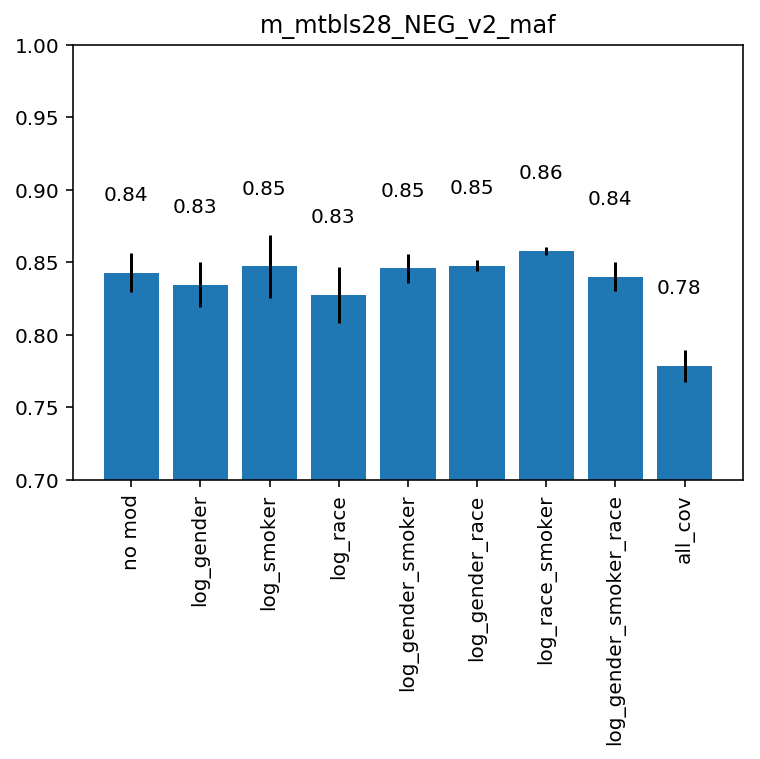

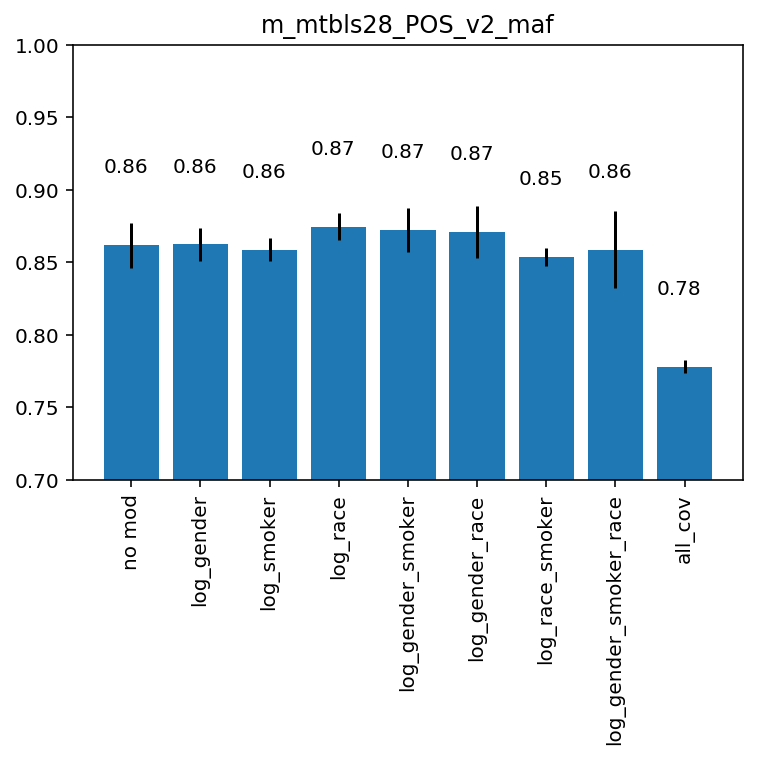

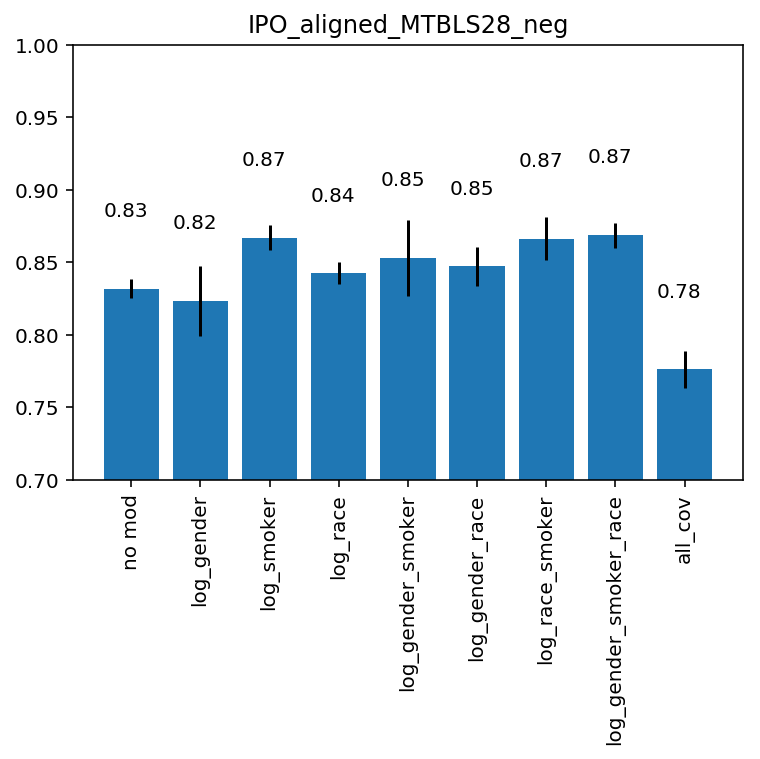

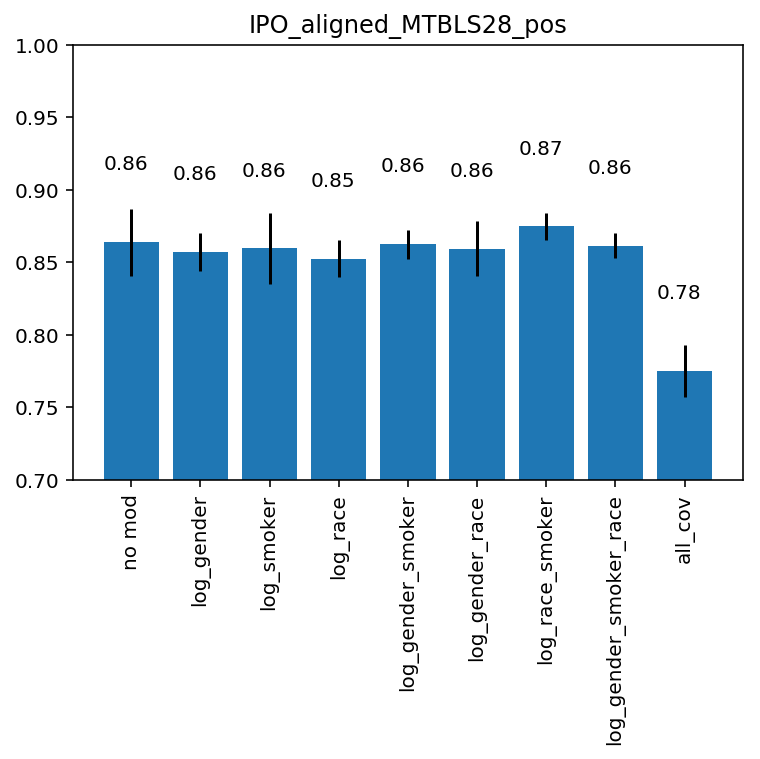

In [12]:
ds_names =  ['m_mtbls28_NEG_v2_maf', 'm_mtbls28_POS_v2_maf', 'IPO_aligned_MTBLS28_neg', 'IPO_aligned_MTBLS28_pos']
# fig, axes = plt.subplots(2, 2)
# for i in range(len(ds_names)):
#     avg = []
#     std = []
#     names = []
#     for data_set in model_aucs:
#         names.append(data_set)
#         avg.append(model_aucs[data_set][i].mean())
#         std.append(model_aucs[data_set][i].std())
#     x = [i for i in range(len(names))]
#     plt.bar(x, avg, yerr=std)
#     plt.xticks(x, names, rotation='vertical')
#     for ind, v in enumerate(avg):
#         plt.text(ind-0.4, v+0.05, '%.2f'%(v))
#     plt.ylim([0.7,1])
#     plt.title(ds_names[i])
#     plt.show()

make_bar_plts(model_aucs, ds_names, y_lim=[0.7,1])
    

In [ ]:
#ST000396, MTBLS358, MTBLS315, MTBLS352, ST000578, ST000888

In [13]:
# ST000396 - to note: no major batch effects! 
# Running without the cancer stage label as well...this appears to be able to predict cancer - shocking!
ST000396 = datasets['ST000396']
# print(ST000396[0]['samples'].head())
patients = list(ST000396[0]['features'].index)
# confounding_d = ST000396[0]['samples'][['Age Group', 'Sex', 'Smoking Status',
#                                         'Lung Cancer Stage','Fasting prior to blood draw (hours)']]
confounding_d = ST000396[0]['samples'][['Age Group', 'Sex', 'Smoking Status','Fasting prior to blood draw (hours)']]
# print(sorted(ST000396[0]['samples']['Fasting prior to blood draw (hours)'].values))
# confounders = {'45-49 ':47,'50-54 ':53,'55-59 ':57,'60-64 ':62,'65-69 ':67,'70-74 ':73, 
#                'Female ':0, 'Male ':1, 'Current ':1, 'Former ':0, '- ':0, '-':0}
confounders = {'45-49 ':0,'50-54 ':1,'55-59 ':2,'60-64 ':3,'65-69 ':4,'70-74 ':5, 
               'Female ':0, 'Male ':1, 'Current ':1, 'Former ':0, '- ':0, '-':0}
confounding_d = confounding_d.loc[patients]
# columns are: ['Age Group', 'Sex', 'Smoking Status', 'Lung Cancer Stage', 'Fasting prior to blood draw (hours)']
confounding_d = confounding_d.replace(confounders).values.astype('int')

# model_aucs = {'no mod':[],'log':[],'log_age':[], 'log_sex':[], 'log_smoking': [], 'log_stage':[], 'log_fasting':[],
#               'log_all':[]}
model_aucs = {'no mod':[],'log':[],'log_age':[], 'log_sex':[], 'log_smoking': [], 'log_fasting':[],'log_all':[], 'cov':[]}

for ds in ST000396:
    X,y, labels = extract_data(ds)
    model_aucs['no mod'].append(fit_l1_log_reg(X,y,labels))
# X is now the log-transformed version:
#     X,y, labels = extract_data(ds, log_scale=True)
#     model_aucs['log'].append(fit_l1_log_reg(X,y, labels))
# get the various combos of covariates:
    model_aucs['log_all'].append(fit_l1_log_reg(X,y,labels,hstck=confounding_d))
    for i in range(confounding_d.shape[1]):
#         names = ['log_age', 'log_sex', 'log_smoking', 'log_stage', 'log_fasting']
        names = ['log_age', 'log_sex', 'log_smoking', 'log_fasting']
        dim = confounding_d[:,i]
        dim = np.expand_dims(dim, axis=1)
        model_aucs[names[i]].append(fit_l1_log_reg(X,y,labels, hstck=dim))
    model_aucs['cov'].append(fit_l1_log_reg(confounding_d, y, labels))
    print(model_aucs)   

/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475:

{'no mod': [array([0.42317823, 0.50183655, 0.5       ])], 'log': [], 'log_age': [array([0.5       , 0.587236  , 0.52112029])], 'log_sex': [array([0.523705  , 0.47153352, 0.565427  ])], 'log_smoking': [array([0.3977173 , 0.5       , 0.42998163])], 'log_fasting': [array([0.43590869, 0.44811754, 0.53259871])], 'log_all': [array([0.51712028, 0.61478421, 0.53259871])], 'cov': [array([0.5       , 0.40151515, 0.32277319])]}


/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475:

{'no mod': [array([0.42317823, 0.50183655, 0.5       ]), array([0.45610184, 0.5       , 0.42470156])], 'log': [], 'log_age': [array([0.5       , 0.587236  , 0.52112029]), array([0.39947322, 0.4862259 , 0.47107438])], 'log_sex': [array([0.523705  , 0.47153352, 0.565427  ]), array([0.37884109, 0.42975207, 0.52938476])], 'log_smoking': [array([0.3977173 , 0.5       , 0.42998163]), array([0.5       , 0.46464646, 0.5       ])], 'log_fasting': [array([0.43590869, 0.44811754, 0.53259871]), array([0.5, 0.5, 0.5])], 'log_all': [array([0.51712028, 0.61478421, 0.53259871]), array([0.5       , 0.46418733, 0.4738292 ])], 'cov': [array([0.5       , 0.40151515, 0.32277319]), array([0.45895522, 0.5       , 0.45982553])]}


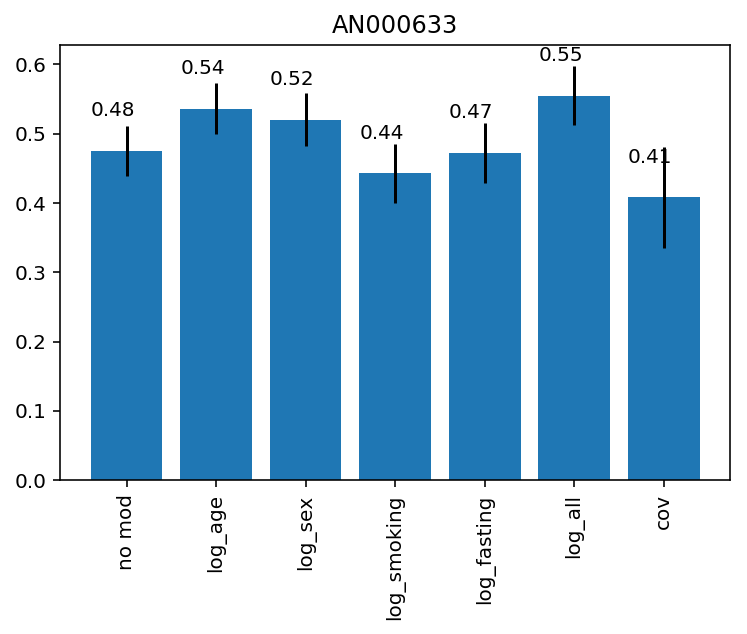

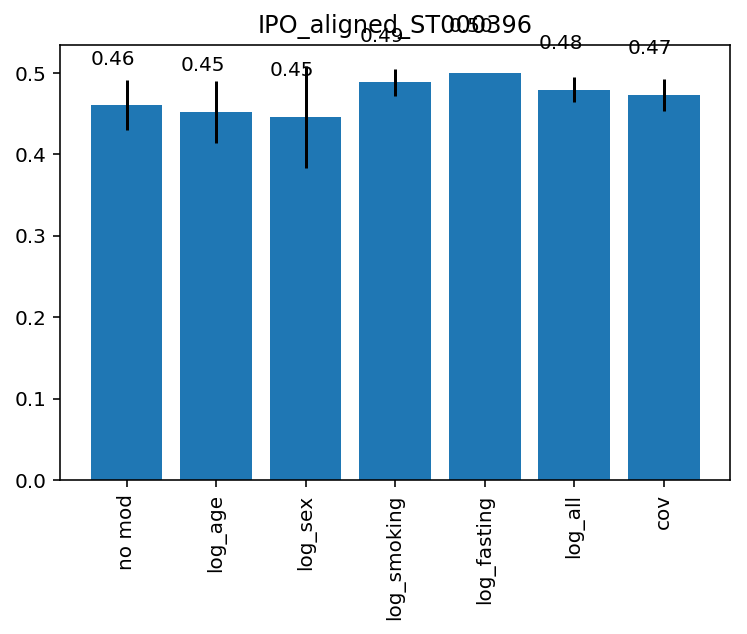

In [14]:
ds_names =  ['AN000633', 'IPO_aligned_ST000396']
make_bar_plts(model_aucs, ds_names)

In [15]:
### IM worried its still not aligned for one of the datasets...

# MTBLS92 : Breast cancer
# Running without the cancer stage label as well...this appears to be able to predict cancer - shocking!
MTBLS92 = datasets['MTBLS92']

df_a = pd.read_csv('a_breastcancerlipidome_metabolite_profiling_mass_spectrometry.txt', sep='\t').set_index('Raw Spectral Data File')['Sample Name']
df_a = df_a.rename(index={ind:'X'+ind[:-4]+'.mzData' for ind in list(df_a.index)})

#not using 'Factor Value[Grade]' due to nans
# not using 'Factor Value[Timepoint]' was the label
model_aucs = {'no mod':[],'log':[],'log_bmi':[], 'log_her2':[], 'log_nstage': [], 'log_tstage':[],
              'log_menopause':[], 'log_er':[],'log_all':[], 'cov':[]}
# confounding_d = MTBLS92[0]['samples'][['Factor Value[BMI]', 'Factor Value[Her2]', 'Factor Value[N-stage]', 'Factor Value[T-stage]', 'Factor Value[Menopause]', 'Factor Value[ER]']]
# y = MTBLS92[1]['labels']
# f = [fi for fi in list(y.index) if 'A' in fi]
# y = y.loc[f].values
# confounding_d = confounding_d.loc[f]
# confounding_d = confounding_d.values.astype('float64')
# mean_bmi = int(np.nanmean(confounding_d[:,0]))
# confounding_d[np.isnan(confounding_d)] = mean_bmi
# labels = [0,1]
# confounding_d, y = shuffle(confounding_d,y)

# for i in range(2):
#     model_aucs['cov'].append(fit_l1_log_reg(confounding_d, y, labels))
# print(model_aucs)


for ds in MTBLS92:
    confounding_d = ds['samples'][['Factor Value[BMI]', 'Factor Value[Her2]', 'Factor Value[N-stage]', 'Factor Value[T-stage]', 'Factor Value[Menopause]', 'Factor Value[ER]']]
    # Get just the discovery data
    if ds['data_set'] == 'IPO_aligned_MTBLS92':
        f = [fi for fi in list(ds['features'].index) if '163' in fi]
        ds['features'] = ds['features'].loc[f]
        ds['labels'] = ds['labels'].loc[f]
        ipo_order = df_a.loc[f].values
        confounding_d = confounding_d.loc[ipo_order]
    if ds['study'] == 'MTBLS92' and ds['data_set'] == 'Author_data':
        f = [fi for fi in list(ds['features'].index) if 'A' in fi]
        ds['features'] = ds['features'].loc[f]
        ds['labels'] = ds['labels'].loc[f]
        confounding_d = confounding_d.loc[f]

    confounding_d = confounding_d.values.astype('float64')
    mean_bmi = int(np.nanmean(confounding_d[:,0]))
    confounding_d[np.isnan(confounding_d)] = mean_bmi

    X,y,labels = extract_data(ds)

    model_aucs['cov'].append(fit_l1_log_reg(confounding_d, y, labels))
    model_aucs['no mod'].append(fit_l1_log_reg(X,y,labels))
# X is now the log-transformed version:
#     X,y, labels = extract_data(ds, log_scale=True)
#     model_aucs['log'].append(fit_l1_log_reg(X,y, labels))
# get the various combos of covariates:
    model_aucs['log_all'].append(fit_l1_log_reg(X,y,labels,hstck=confounding_d))
    for i in range(confounding_d.shape[1]):
        names = ['log_bmi', 'log_her2', 'log_nstage', 'log_tstage',
                 'log_menopause', 'log_er', 'log_timepoint']
        dim = confounding_d[:,i]
        dim = np.expand_dims(dim, axis=1)
        model_aucs[names[i]].append(fit_l1_log_reg(X,y,labels, hstck=dim))
#     model_aucs['cov'].append(fit_l1_log_reg(confounding_d, y, labels))
    print(model_aucs)   

{'no mod': [array([0.89921171, 0.83496262, 0.74180564])], 'log': [], 'log_bmi': [array([0.88175676, 0.80103508, 0.78320874])], 'log_her2': [array([0.72972973, 0.8786659 , 0.84588844])], 'log_nstage': [array([0.80686937, 0.83438758, 0.85853939])], 'log_tstage': [array([0.88231982, 0.87636573, 0.80851064])], 'log_menopause': [array([0.87218468, 0.82116159, 0.82921219])], 'log_er': [array([0.85698198, 0.78148361, 0.83553767])], 'log_all': [array([0.79560811, 0.88154112, 0.83381254])], 'cov': [array([0.48564189, 0.5       , 0.48562392])]}
{'no mod': [array([0.89921171, 0.83496262, 0.74180564]), array([0.81137387, 0.89591719, 0.83898792])], 'log': [], 'log_bmi': [array([0.88175676, 0.80103508, 0.78320874]), array([0.82207207, 0.78148361, 0.79873491])], 'log_her2': [array([0.72972973, 0.8786659 , 0.84588844]), array([0.89752252, 0.82863715, 0.8079356 ])], 'log_nstage': [array([0.80686937, 0.83438758, 0.85853939]), array([0.89864865, 0.83898792, 0.7320299 ])], 'log_tstage': [array([0.88231982

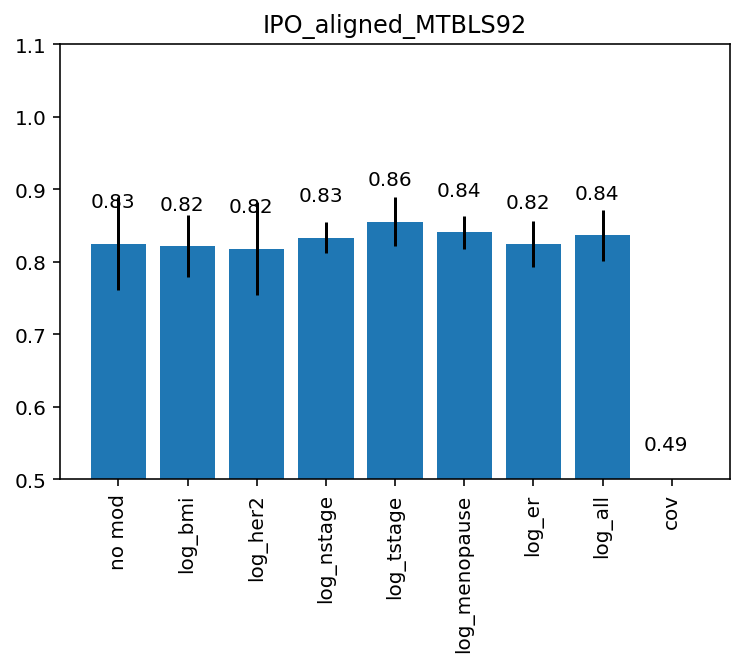

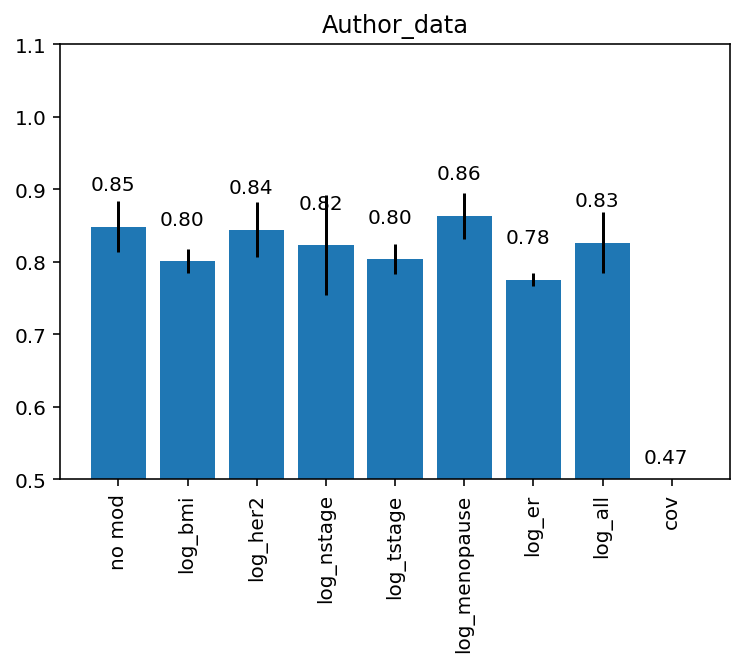

In [16]:
ds_names =  []
for ds in MTBLS92:
    ds_names.append(ds['data_set'])
make_bar_plts(model_aucs, ds_names, y_lim=[0.5,1.1])

In [31]:
# FINALLY IN THE RIGHT ORDER! had to change the order of the covariates for each dataset...
# MTBLS315 : Breast cancer
# Running without the cancer stage label as well...this appears to be able to predict cancer - shocking!
df_a_gc = pd.read_csv('a_GC_nmfi_and_bsi_diagnosis.txt', sep='\t').set_index('Raw Spectral Data File')['Sample Name']
df_a_gc_auth = df_a_gc.rename(index={ind: str(int(ind[:-6])) for ind in list(df_a_gc.index)})
df_a_gc_IPO = df_a_gc.rename(index={ind: 'X'+ind[:-4]+'.mzData' for ind in list(df_a_gc.index)})
df_a_gc_XCMS = df_a_gc.rename(index={ind: ind[:-4] for ind in list(df_a_gc.index)})
df_a_lc = pd.read_csv('a_LC_nmfi_and_bsi_diagnosis.txt', sep='\t').set_index('Raw Spectral Data File')['Sample Name']
df_a_lc_auth = df_a_lc.rename(index={ind: ind[:-6] for ind in list(df_a_lc.index)})
df_a_lc_IPO = df_a_lc.rename(index={ind: 'X'+ind[:-6].replace('-', '.')+'.mzXML' for ind in list(df_a_lc.index)})
df_a_uplc_neg = pd.read_csv('a_UPLC_NEG_nmfi_and_bsi_diagnosis.txt', sep='\t').set_index('Raw Spectral Data File')['Sample Name']
df_a_uplc_neg_auth = df_a_uplc_neg.rename(index={ind: ind[:-5] for ind in list(df_a_uplc_neg.index)})
df_a_uplc_neg_IPO = df_a_uplc_neg.rename(index={ind: 'X'+ind[:-5]+'.mzML' for ind in list(df_a_uplc_neg.index)})
df_a_uplc_neg_XCMS = df_a_uplc_neg.rename(index={ind: ind[:-5] for ind in list(df_a_uplc_neg.index)})
df_a_uplc_pos = pd.read_csv('a_UPLC_POS_nmfi_and_bsi_diagnosis.txt', sep='\t').set_index('Raw Spectral Data File')['Sample Name']
df_a_uplc_pos_auth = df_a_uplc_pos.rename(index={ind: ind[:-5] for ind in list(df_a_uplc_pos.index)})
df_a_uplc_pos_IPO = df_a_uplc_pos.rename(index={ind: 'X'+ind[:-5]+'.mzML' for ind in list(df_a_uplc_pos.index)})

MTBLS315 = datasets['MTBLS315']
confounding_d = MTBLS315[0]['samples'][['Factor Value[height]', 'Factor Value[weight]', 'Factor Value[age]', 'Factor Value[Gender]', 'Factor Value[severe malnutrition]',
                                        'Factor Value[prior antimalaria treatment]', 'Factor Value[prior antibiotic treatment]']]
confounders = {'male':1, 'female':0, 'yes':1, 'no':0}
confounding_d = confounding_d.replace(confounders)#.values.astype('float64')

#[['Factor Value[blood glucose]', 'Factor Value[diff_basophils]', 'Factor Value[diff_eosinophils]', 
# 'Factor Value[diff_monocytes]', 'Factor Value[diff_lymphocytes]', 'Factor Value[diff_neutrophils]', 'Factor Value[platelet count]'
# 'Factor Value[mean corpuscular hemoglobin concentration]', 'Factor Value[mean corpuscular hemoglobin ]',
# 'Factor Value[mean corpuscular volume ]', 'Factor Value[hematocrit]','Factor Value[hemoglobin]', 
# 'Factor Value[total red blood cell count]', 'Factor Value[total white blood cell count]', 'Factor Value[P. falciparum parasite density]'
# 'Factor Value[temperature]', 'Factor Value[duration illness prior to hospital admission]', 
# 'Factor Value[height]', 'Factor Value[weight]', 'Factor Value[age]', 'Factor Value[Gender]', 'Factor Value[severe malnutrition]'
# 'Factor Value[prior antimalaria treatment]', 'Factor Value[prior antibiotic treatment]']]

model_aucs = {'no mod':[],'log':[],'log_height':[], 'log_weight':[], 'log_age': [], 'log_gender':[], 'log_malnut':[],
              'log_pri_antimal':[], 'log_pri_antibio':[],'log_all':[], 'cov':[]}
maps = [df_a_gc_auth, df_a_lc_auth, df_a_uplc_neg_auth, df_a_uplc_pos_auth,
        df_a_gc_IPO, df_a_lc_IPO, df_a_uplc_neg_IPO, df_a_uplc_pos_IPO,
        df_a_gc_XCMS, df_a_uplc_neg_XCMS]
for ds, name_map in zip(MTBLS315, maps):
    labels = list(ds['features'].index)
    new_labels = name_map.loc[labels].values
    conf_d = confounding_d.loc[new_labels].values.astype('float64')
    means = np.nanmean(conf_d, axis=0)
    inds = np.where(np.isnan(conf_d))
    conf_d[inds] = np.take(means, inds[1])
    
    X,y, labels = extract_data(ds)
    model_aucs['cov'].append(fit_l1_log_reg(conf_d, y, labels))
    model_aucs['no mod'].append(fit_l1_log_reg(X,y,labels))
# X is now the log-transformed version:
#     X,y, labels = extract_data(ds, log_scale=True)
#     model_aucs['log'].append(fit_l1_log_reg(X,y, labels))
# get the various combos of covariates:
    model_aucs['log_all'].append(fit_l1_log_reg(X,y,labels,hstck=conf_d))
    names = ['log_height', 'log_weight', 'log_age', 'log_gender', 'log_malnut',
             'log_pri_antimal', 'log_pri_antibio']
    for i in range(conf_d.shape[1]):
        dim = conf_d[:,i]
        dim = np.expand_dims(dim, axis=1)
        model_aucs[names[i]].append(fit_l1_log_reg(X,y,labels, hstck=dim))
    print(model_aucs)   

coef for confounders:  [ 1.18259653  0.         -2.63741425 -2.03498773  1.05158593 -1.98600447
 -3.11709389]
coef for confounders:  [0. 0. 0. 0. 0. 0. 0.]
coef for confounders:  [ 0.15436521 -0.95110192 -1.73318567 -2.69453575  3.44142226 -1.21798401
 -1.85209843]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [-1.11646971]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [-2.69579706]
coef for confounders:  [0.]
coef for confounders:  [5.20411016]
coef for confounders:  [3.30360211]
coef for confounders:  [-1.8361214]
coef for confounders:  [0.]
coef for confounders:  [-2.83194405]
coef for confounders:  [-0.89678581]
coef for confounders:  [-4.57511939]
coef for confounders:  [0.]
{'no mod': [array([0.82407407, 0.94949495, 0.73737374])], 'log': [], 'log_hei

coef for confounders:  [0. 0. 0. 0. 0. 0. 0.]
coef for confounders:  [0. 0. 0. 0. 0. 0. 0.]
coef for confounders:  [0. 0. 0. 0. 0. 0. 0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [-0.18549264]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
{'no mod': [array([0.82407407, 0.94949495, 0.73737374]), array([0.89814815, 0.94949495, 0.70707071]), array([0.88888889, 0.93939394, 0.85858586]), array([0.93518519, 0.90909091, 0.88888889]), array([0.50925926, 0.5959596 , 0.56565657])], 'log': [], 'log_height': [a

coef for confounders:  [0. 0. 0. 0. 0. 0. 0.]
coef for confounders:  [0. 0. 0. 0. 0. 0. 0.]
coef for confounders:  [0. 0. 0. 0. 0. 0. 0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
{'no mod': [array([0.82407407, 0.94949495, 0.73737374]), array([0.89814815, 0.94949495, 0.70707071]), array([0.88888889, 0.93939394, 0.85858586]), array([0.93518519, 0.90909091, 0.88888889]), array([0.50925926, 0.5959596 , 0.56565657]), array([0.92592593, 0.95959596, 0.8585

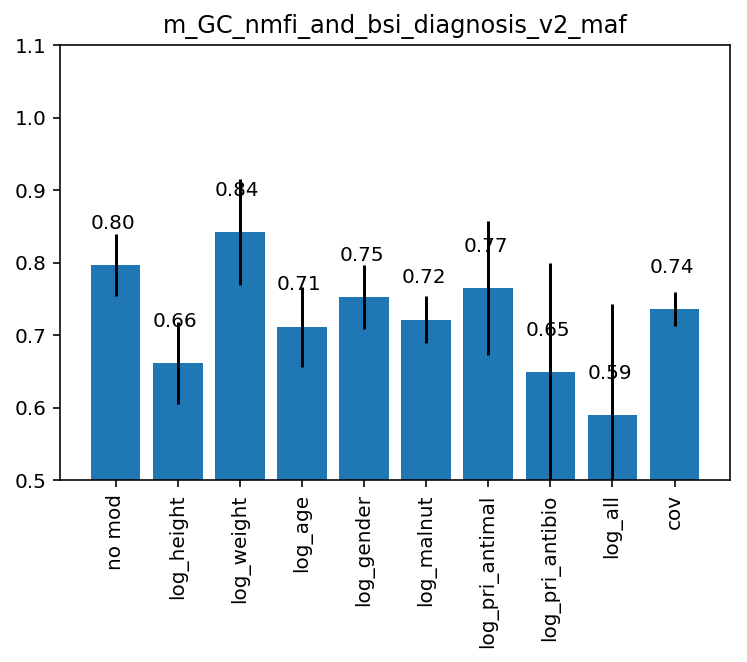

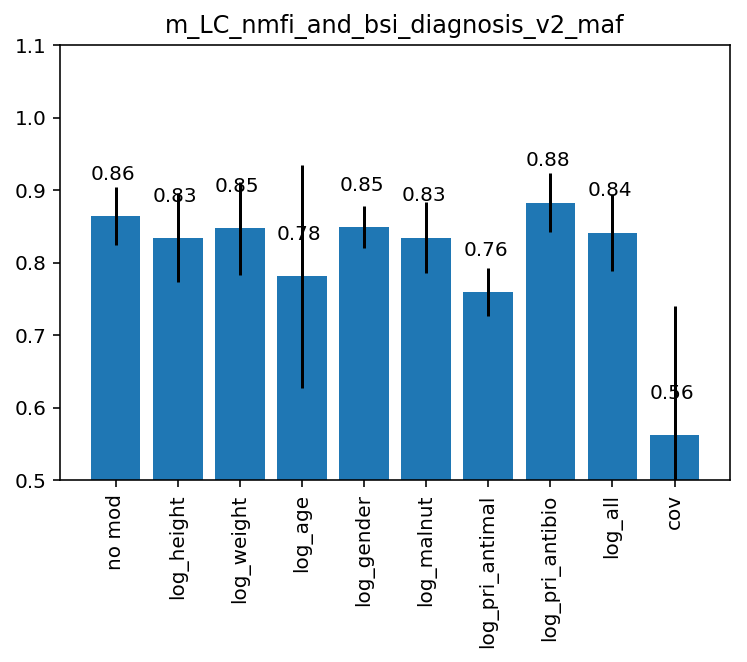

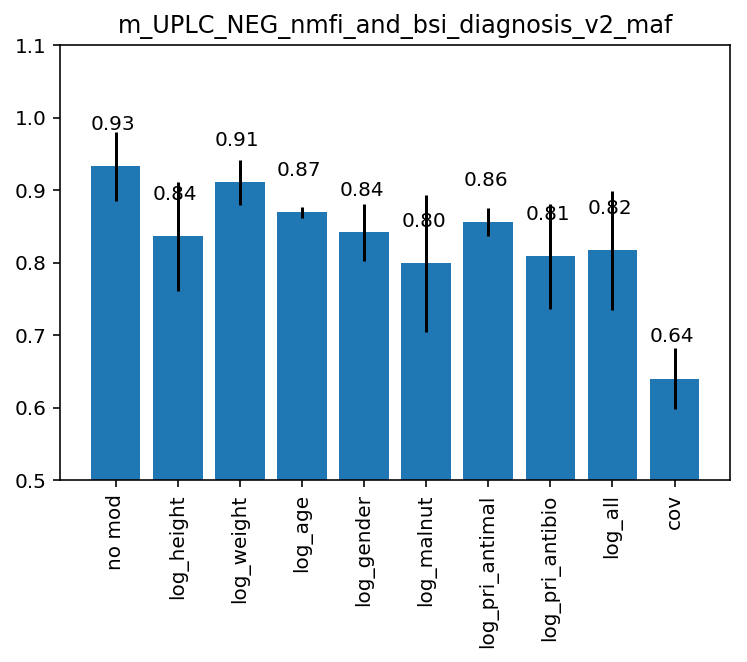

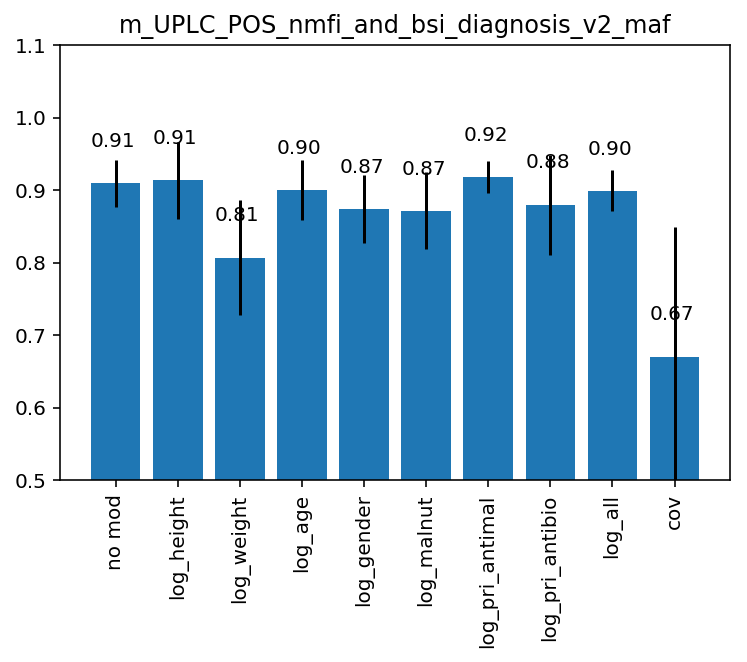

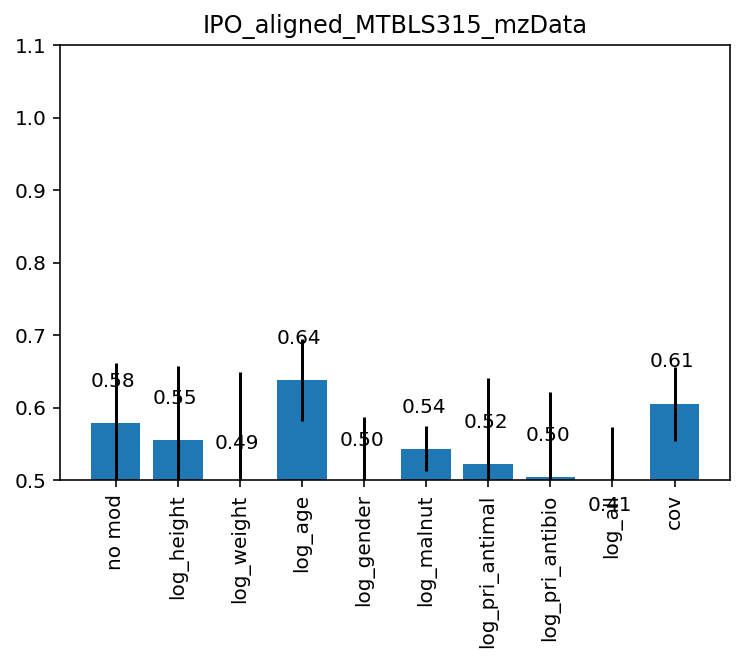

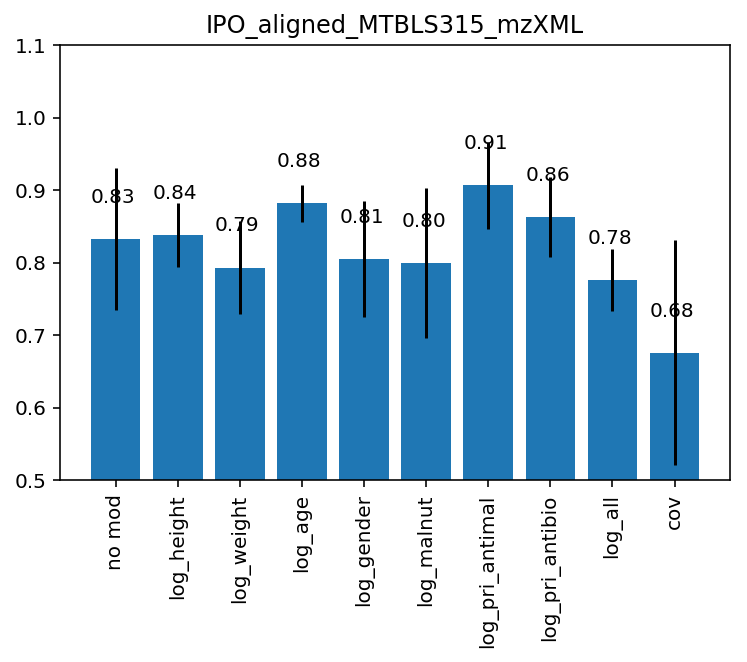

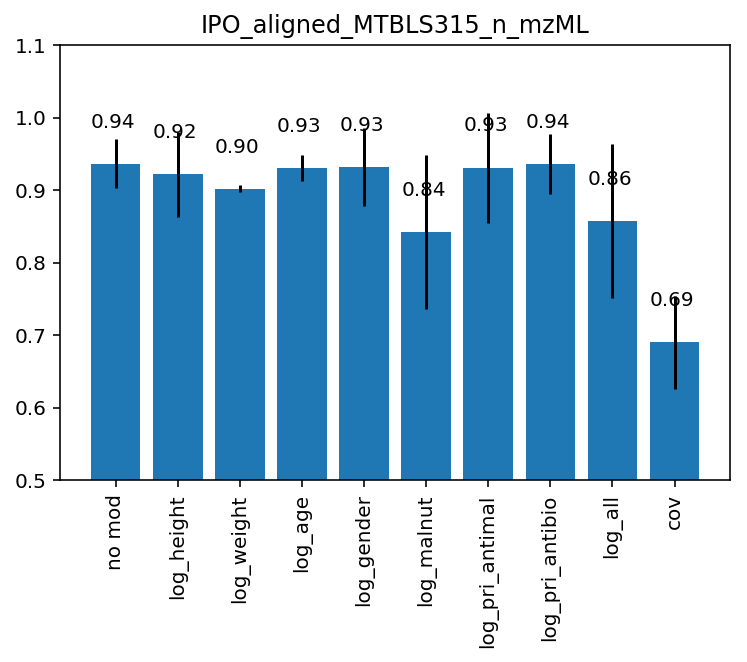

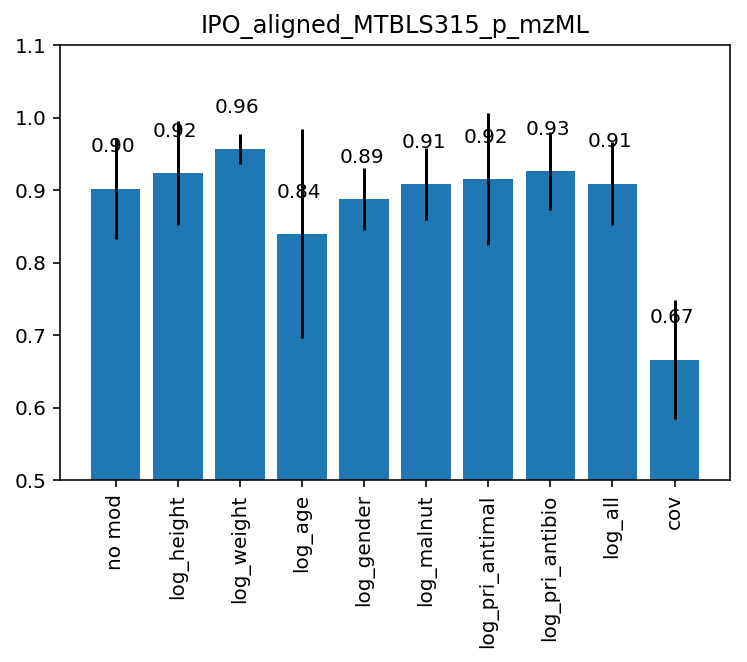

In [18]:
ds_names =  []
for ds in MTBLS315:
    ds_names.append(ds['data_set'])
make_bar_plts(model_aucs, ds_names, y_lim=[0.5,1.1])

In [32]:
# ST000284
# colorectal cancer
ST000284 = datasets['ST000284']
confounding_d = ST000284[0]['samples'][['Age at  Consent', 'Gender', 'Smoking condition', 'Alcohol consumption', 'Height [cm]', 'Weight [kg]', 'BMI [kg/mÂ²]']]
replace = {'M':1, 'F':0, 'Some days':1, 'Everyday':2, 'Non-smoker':0, 
           'At least 1 drink/day':2,'Sometimes':1, 'No alcohol':0, '-':np.nan}
confounding_d = confounding_d.replace(replace)
# mean filling
confounding_d = confounding_d.values.astype('float64')
means = np.nanmean(confounding_d, axis=0)
inds = np.where(np.isnan(confounding_d))
confounding_d[inds] = np.take(means, inds[1])
model_aucs = {'no mod':[],'log':[],'log_age':[], 'log_gender':[], 'log_smoking': [], 'log_alcohol':[], 'log_height':[],
              'log_weight':[], 'log_bmi':[],'log_all':[], 'cov':[]}

X,y, labels = extract_data(ST000284[0])
# print(confounding_d, y)
model_aucs['cov'].append(fit_l1_log_reg(confounding_d, y, labels))
# print(fit_l1_log_reg(np.expand_dims(confounding_d[:,4],axis=1),y,labels))
model_aucs['no mod'].append(fit_l1_log_reg(X,y,labels))
# X is now the log-transformed version:
# X,y, labels = extract_data(ST000284[0], log_scale=True)
# model_aucs['log'].append(fit_l1_log_reg(X,y, labels))
# get the various combos of covariates:
model_aucs['log_all'].append(fit_l1_log_reg(X,y,labels,hstck=confounding_d))
names = ['log_age', 'log_gender', 'log_smoking', 'log_alcohol', 
         'log_height', 'log_weight', 'log_bmi']
for i in range(confounding_d.shape[1]):
    print('confounder: {}'.format(i))
    dim = confounding_d[:,i]
    dim = np.expand_dims(dim, axis=1)
    model_aucs[names[i]].append(fit_l1_log_reg(X,y,labels, hstck=dim))
print(model_aucs)   

coef for confounders:  [0. 0. 0. 0. 0. 0. 0.]
coef for confounders:  [0. 0. 0. 0. 0. 0. 0.]
coef for confounders:  [ 0.         -2.19233094 -4.60681557  0.          1.00489885  0.
  0.        ]
confounder: 0
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
confounder: 1
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [-1.81540888]
confounder: 2
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
confounder: 3
coef for confounders:  [-3.23301749]
coef for confounders:  [0.]
coef for confounders:  [0.]
confounder: 4
coef for confounders:  [0.]
coef for confounders:  [4.52366977]
coef for confounders:  [0.]
confounder: 5
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
confounder: 6
coef for confounders:  [0.]
coef for confounders:  [0.]
coef for confounders:  [0.]
{'no mod': [array([0.67401216, 0.69908815, 0.69099379])], 'log': [], 'log_age': [array([0.5744

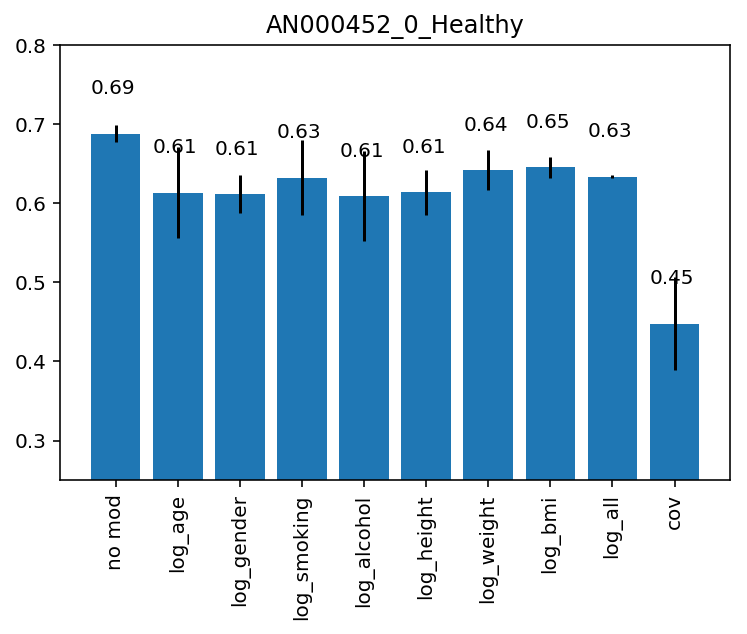

IndexError: list index out of range

In [34]:
ds_names =  []
for ds in ST000284:
    ds_names.append(ds['data_set'])
make_bar_plts(model_aucs, ds_names, y_lim=[0.25,0.8])